In [1]:
import torch
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, non_max_suppression, apply_classifier, scale_coords, xyxy2xywh, \
    strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized
import numpy as np
import matplotlib.pyplot as plt
import os
import collections
import time
from PIL import Image

def detect(opt):
    res=[]
    source, weights, view_img, save_txt, imgsz = opt.source, opt.weights, opt.view_img, opt.save_txt, opt.img_size
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('c://', 'rtmp://', 'http://'))

    # Directories
    save_dir = Path(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(opt.device)
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    imgsz = check_img_size(imgsz, s=model.stride.max())  # check img_size
    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        view_img = True
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz)
    else:
        save_img = True
        dataset = LoadImages(source, img_size=imgsz)

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    _ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment=opt.augment)[0]

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
        t2 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f'{n} {names[int(c)]}s, '  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        label = f'{names[int(cls)]} {conf:.2f}'
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)
#                     res.append(xyxy)
                    temp=[]
                    for i in xyxy:
                        temp.append(float(i))
                    res.append(temp)
            # Print time (inference + NMS)
            print(f'{s}Done. ({t2 - t1:.3f}s)')

            # Stream results
            if view_img:
                cv2.imshow(str(p), im0)
                if cv2.waitKey(1) == ord('q'):  # q to quit
                    raise StopIteration
            plt.imshow(im0)
            plt.show()
            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer

                        fourcc = 'mp4v'  # output video codec
                        fps = vid_cap.get(cv2.CAP_PROP_FPS)
                        w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                        h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*fourcc), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        print(f"Results saved to {save_dir}{s}")

    print(f'Done. ({time.time() - t0:.3f}s)')
    return res

In [2]:
def predict(weights,source,conf):
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default=weights, help='model.pt path(s)')
    parser.add_argument('--source', type=str, default=source, help='source')  # file/folder, 0 for webcam
    parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)')
    parser.add_argument('--conf-thres', type=float, default=conf, help='object confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.35, help='IOU threshold for NMS')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--view-img', action='store_true', help='display results')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --class 0, or --class 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default='runs/detect', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    opt, unknown = parser.parse_known_args()
    print(opt)
    return detect(opt=opt)

In [3]:
def getBounding(path):
    %matplotlib inline
    count=0
    abc=predict(r'weights\eq_detection\equations_detection-2912.pt',path,0.72)
    image = cv2.imread(path, cv2.COLOR_BGR2RGB)
    image1= cv2.imread(path, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    xs=[]
    ys=[]
    crop_img=[]
    color=(255,255,0)
    ###########################
    #Print each equations:
    for i in abc:
        i=[int(j) for j in i]
        xs+=[i[0],i[2]]
        ys+=[i[1],i[3]]
        crop_img.append(image1[i[1]:i[3],int(i[0]):i[2]].copy())
        image = cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), color, 3) 
    count=0
    rd=str(int(time.time()))
    foldername=r"static/single_eq/"
    currentpath=foldername+rd
    os.makedirs(currentpath)
    for i in crop_img:
        im = Image.fromarray(i)
        im.save(currentpath+'/'+str(count)+".jpg")
        count+=1
    crop_chars=[]  
    print(currentpath)
    for i in os.listdir(currentpath):
        abc=predict(r"weights\eq_detection\character_detection_weights.pt",currentpath+'/'+i,0.3)
        image = cv2.imread(currentpath+'/'+i, cv2.COLOR_BGR2RGB)
        temp={}
        for j in abc:
            j=[int(k) for k in j]
    #        crop_chars.append(image[j[1]:j[3],j[0]:j[2]].copy())
#             if(not (j[0] in range(5)) and not (j[2] in range(10))):
            print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x',j[0],'w=',j[2])
            if(not (j[0] in range(2)) and not (j[2] in range(10))):
                temp[j[0]]=image[j[1]:j[3],j[0]:j[2]].copy()
            else:
                print("dayyyyyyyyyyyyyy")
                plt.imshow(image[j[1]:j[3],j[0]:j[2]])
                plt.show()
        od = collections.OrderedDict(sorted(temp.items()))
        _=[]
        for k,v in od.items(): 
            _.append(v)
        crop_chars.append(_)
    for i in crop_chars:
        for j in i:
            plt.imshow(j)
            plt.show()
    print(">>>>>>>>>>>>>>>>>>>>"+str(count))
    return crop_chars,['static/single_eq/'+rd+'/'+str(i)+'.jpg' for i in range(count)]

In [4]:
import numpy as np
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
chars_range={0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'x', 11:'y', 12:'z', 13:'a', 14:'b', 15:'-', 16:'=', 17:'+'}

In [5]:
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
def preprocessingImgs(crop_imgs):
    ims=[]
    for i in crop_imgs:
        temp=[]
        for j in i:
            h, w, c = j.shape
            img=rgb2gray(j)
            yen_threshold = threshold_yen(img)
            img = rescale_intensity(img, (0, yen_threshold), (0, 255))
            thresh = 220
            img = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY_INV)[1]
#         img = cv2.bitwise_not(img)
            height, width= img.shape
            img=img.reshape(height,width,1)
            height, width, channels = img.shape
#             print((height, width, channels))
            pad=0
            if(width>height):
                left=right=pad
                top=bottom=int((width+2*pad-height)/2)
            else:
                top=bottom=pad
                left=right=int((height+2*pad-width)/2)
            hhh = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_ISOLATED)
            h,w=hhh.shape
            s=max(h,w)
            hhh=cv2.resize(hhh,(s,s))
#             print(hhh.shape)
            hhh=cv2.resize(hhh,(28,28))
            temp.append(hhh.reshape(28,28,1))
#             plt.imshow(hhh)
#             plt.show()
        ims.append(temp)
    return [np.array(i) for i in ims]

In [6]:
import re as regex
import copy
def validate(test):
    _test=copy.copy(test)
#     test="x+2y=3 2z-3y--1"
    #######################################valid x=z#######################################
    # for i in range(len(test)):
    #     if(test[i].isalpha()):
    #         variables[test[i]]=test.count(test[i])
#     numbers_of_variables=len(list(variables))
    numbers_of_valid_variables=len(test.split())
    # print(variables)
    if(numbers_of_valid_variables==2):
        test=test.replace('z','x')
        test=test.replace('4=','y=')
    #######################################valid = and -#######################################
    equations=test.split()
    for i in range(len(equations)):
        if('--' in equations[i]):
            equations[i]=equations[i].replace('--','=-')
        if('==' in equations[i]):
            equations[i]=equations[i].replace('==','=')
        if('-=' in equations[i]):
            equations[i]=equations[i].replace('-=','=')
        if('=' not in equations[i]):
            temp=list(equations[i])
            temp[equations[i].rfind('-')]='='
            equations[i]=''.join(temp)
        ######################################3
        while(equations[i].endswith('+') or equations[i].endswith('-') or equations[i].endswith('=')):
            equations[i]=equations[i][:-1]
        while(equations[i].startswith('+') or equations[i].endswith('-') or equations[i].endswith('=')):
            equations[i]=equations[i][1:]
        if(len(equations[i].split('=')[-1])!=1):
            while('=0' in equations[i]):
                equations[i]=equations[i].replace('=0','=')
        if(len(equations)==3):
            while('2=' in equations[i]):
                equations[i]=equations[i].replace('2=','z=')
         ######################################3
       
        MATCH_INVALID=regex.findall('(?:x|y|z)[0-9]',equations[i])
        for c in MATCH_INVALID:
            while(c in equations[i]):
                equations[i]=equations[i].replace(c,c[:-1])
    test=' '.join(equations)
    print("Before: "+_test+">>>> After: "+test)
    return test

In [7]:
from keras.models import load_model
def classify(ims_arr,choice):
    conf_threshold=0.3
    md = load_model(r"weights\classify\last_weights.h5")
    ims=ims_arr
    conf=[]
    result=[]
    confidences=[]
    for i in ims:
        result.append(md.predict_classes(i/255.))
        confidences.append(md.predict(i/255.))
    f=""
    _result=[]
    for i in range(len(ims_arr)):
        _t=[]
        for j in range(len(ims_arr[i])):
            print(chars_range[result[i][j]],' | ',max(confidences[i][j]))
            if(max(confidences[i][j])>=conf_threshold):
                _t.append([chars_range[result[i][j]],max(confidences[i][j])]) 
            plt.imshow(ims_arr[i][j])
            plt.show()
        _result.append(_t)
    
    for i in _result:
        for j in i:
            f+=j[0]
        f+=" "
    f=f.strip()
    if(choice==0):
        f=validate(f)
    else:
        f=validate2(f)
    print(f)
    return f.split()

In [8]:
from sympy import solve, Poly, Eq, Function, exp
from sympy.abc import x, y, z, a, b
from sympy import *
from sympy.parsing.sympy_parser import parse_expr
def process_str(x, i) :
    list_type = []
    for a in x :
        if a.isalpha() :
            list_type.append(2)
        if a.isnumeric() :
            list_type.append(1) 
        if a in ["+", "-"] :
            list_type.append(0)
    string = ""
    for b in range(len(list_type)-1) :
        if list_type[b] ==1 and list_type[b+1] == 2 :
            string += x[b] + "*"
        elif list_type[b] == 2 and list_type[b+1] == 2 :
            string += x[b] + "*" 
        elif list_type[b] == 2 and list_type[b+1] == 1 :
            string += x[b] + "**"
        else :
            string += x[b]
    string += x[-1]

    if i == 1:
        if string[0] == "+" :
            string = "-" + string[1:]
        else :
            string = "+" + string[1:]
    return string
def eq_solver(equation) :
    list_eq = []
    for eq in equation :
        string = ""
        #left : 0 , right : 1
        for i, side in enumerate(eq.split("=")) :
            if side[0] not in ["+", "-"] :
                side = "+" + side
            pos_sign = [i for i, char in enumerate(side) if char in ["+","-"]]
            pos_sign.append(len(side))
            
            for j in range(len(pos_sign)-1) :
                string += process_str(side[pos_sign[j] : pos_sign[j+1]], i)
        list_eq.append(string)
    print('list equation:',list_eq)
    result = solve([parse_expr(i) for i in list_eq]) 

    #print(result)
    str_result = ""
    if type(result) == dict :
        for i,key in enumerate(result) :
            if i == 0 :
                if len(result) == 1:
                    str_result += "( {} = {} )".format(latex(key), latex(result[key]))
                else :
                    str_result += "( {} = {} ,".format(latex(key), latex(result[key]))
            elif i == len(result) -1 :
                str_result += " {} = {} )".format(latex(key), latex(result[key]))
            else:
                str_result += " {} = {} ,".format(latex(key), latex(result[key]))
        return [str_result]
            
    else :
        if len(result) == 0 :
            return ["The\ equation\ has\ no\ solution!"]
        list_result = []
        for r in result : 
            str_result = ""
            for i, key in enumerate(r) :
                if i == 0 :
                    if len(r) == 1:
                        str_result += "( {} = {} )".format(latex(key), latex(r[key]))
                    else :
                        str_result += "( {} = {} ,".format(latex(key), latex(r[key]))
                elif i == len(r) -1 :
                    str_result += " {} = {} )".format(latex(key), latex(r[key]))
                else:
                    str_result += " {} = {} ,".format(latex(key), latex(r[key]))
         #Replace "//" to "/"
            list_result.append(str_result)
        return list_result

In [9]:
def convertToLatext(formula):
    import requests
    headers = {
        "Content-type": "application/x-www-form-urlencoded",
    }
    data = {
        "auth": {
            "user": "guest",
            "password": "guest"
        },
        "latex": formula,
        "resolution": 600,
        "color": "000000"
    }
    r = requests.post('http://latex2png.com/api/convert', headers=headers, json=data) # the right way to send POST requests
    print(r.json())  # print the json
    image_url = "http://latex2png.com" + r.json()['url']
    return image_url

In [10]:
def cropChar_using_Countours(path):
    %matplotlib inline
    image=cv2.imread(path,cv2.COLOR_BGR2GRAY)
    image=rgb2gray(image)
    yen_threshold = threshold_yen(image)
    image = rescale_intensity(image, (0, yen_threshold), (0, 255))
    thresh = 230
    image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY_INV)[1]
    plt.imshow(image)
    plt.show()
######################################################################################################################3
    cv2.imwrite(path,image)
    image = cv2.imread(path)
    im_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    im_blur = cv2.GaussianBlur(im_gray,(5,5),0)
    im,thre = cv2.threshold(im_blur,100,255,cv2.THRESH_BINARY)
    contours,hierachy = cv2.findContours(thre,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(cnt) for cnt in contours]
    # print(len(rects))
    # rects,weights = cv2.groupRectangles(rects, 1, 1.75)
    print(len(rects))
    # print(contours)
    cropimg=[]
    image_c=image.copy()
    temp={}
    crop_chars=[]
    s=0
    for i in rects:
        (x,y,w,h) = i
        s=s+h*w
    s=s/len(rects)
    print("S_avg=",h*w)
    for i in rects:
        (x,y,w,h) = i
        if(w*h>s*1/10):
            print("s=",w*h)
            crop = image_c[y:y+h,x:x+w]
#             plt.imshow(crop)
#             plt.show()
            cropimg.append(crop)
#     j=[int(k) for k in j]
#             if(not (x in range(5)) and not (w in range(10))):
            print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x',x,'w=',w)
            if(not (x in range(2)) and not (w in range(10))):
                temp[x]=image_c[y:y+h,x:x+w].copy()
#             print("x0====================",x)
#     plt.imshow(image)
#     plt.show()
    od = collections.OrderedDict(sorted(temp.items()))    
    for k,v in od.items(): 
        crop_chars.append(v)
    crops=[]
    count=0
    for i in crop_chars:
        height, width,_ = i.shape
        pad=10
        if(width>height):
            left=right=pad
            top=bottom=int((width+2*pad-height)/2)
        else:
            top=bottom=pad
            left=right=int((height+2*pad-width)/2)
        hhh = cv2.copyMakeBorder( i, top, bottom, left, right, cv2.BORDER_CONSTANT)
        h,w,_=hhh.shape
        s=max(h,w)
        hhh=cv2.resize(hhh,(s,s))
        hhh=cv2.resize(hhh,(28,28))
        tuankq=hhh
        count=count+1
        print(">>>>>>>>>",hhh.shape)
        __=cv2.cvtColor(hhh,cv2.COLOR_RGBA2GRAY)
        __=np.reshape(__,(28,28,1))
#         new_array = cv2.resize(new_array, (28,28,1))
#         __=np.reshape(hhh,(28,28,1))
        print(__.shape)
        crops.append(__)
#         plt.imshow(hhh)
#         plt.show()
    return crops
import re as regex
def validate2(test):
    _test=test
#     test="x+2y=3 2z-3y--1"
    #######################################valid x=z#######################################
    # for i in range(len(test)):
    #     if(test[i].isalpha()):
    #         variables[test[i]]=test.count(test[i])
#     numbers_of_variables=len(list(variables))
    numbers_of_valid_variables=len(test.split())
    # print(variables)
    if(numbers_of_valid_variables==2):
        test=test.replace('z','x')
        test=test.replace('4=','y=')
    #######################################valid = and -#######################################
    equations=test.split()
    for i in range(len(equations)):
        ######################################3
        if('--' in equations[i]):
            equations[i]=equations[i].replace('--','=')
         ######################################3
        if('==' in equations[i]):
            equations[i]=equations[i].replace('==','=')
         ######################################3
        if('-=' in equations[i]):
            equations[i]=equations[i].replace('-=','=')
         ######################################3
        if('=' not in equations[i]):
            temp=list(equations[i])
            temp[equations[i].rfind('-')]='='
            equations[i]=''.join(temp)
         ######################################3
        while(equations[i].endswith('+') or equations[i].endswith('-') or equations[i].endswith('=')):
            equations[i]=equations[i][:-1]
        while(equations[i].startswith('+') or equations[i].endswith('-') or equations[i].endswith('=')):
            equations[i]=equations[i][1:]
         ######################################3
        MATCH_INVALID=regex.findall('(?:x|y|z)[0-9]',equations[i])
        for c in MATCH_INVALID:
            while(c in equations[i]):
                equations[i]=equations[i].replace(c,c[:-1])
        if(len(equations)==3):
            while('2=' in equations[i]):
                equations[i]=equations[i].replace('2=','z=')
    test=' '.join(equations)
    print("Before: "+_test+">>>> After: "+test)
    return test
def getBounding2(path):
    %matplotlib inline
    count=0
    abc=predict(r'weights\eq_detection\equations_detection-2912.pt',path,0.72)
    image = cv2.imread(path, cv2.COLOR_BGR2RGB)
    image1= cv2.imread(path, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    xs=[]
    ys=[]
    crop_img=[]
    color=(255,255,0)
    ###########################
    #Print each equations:
    for i in abc:
        i=[int(j) for j in i]
        xs+=[i[0],i[2]]
        ys+=[i[1],i[3]]
        crop_img.append(image1[i[1]:i[3],int(i[0]):i[2]].copy())
        image = cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), color, 3) 
    count=0
    rd=str(int(time.time()))
    foldername=r"static/single_eq/"
    currentpath=foldername+rd
    os.makedirs(currentpath)
    for i in crop_img:
        im = Image.fromarray(i)
        im.save(currentpath+'/'+str(count)+".jpg")
        count+=1
    crop_chars=[]  
    print(currentpath)
    for i in os.listdir(currentpath):
        crop_chars.append(cropChar_using_Countours(currentpath+'/'+i))
    return crop_chars,['static/single_eq/'+rd+'/'+str(i)+'.jpg' for i in range(count)]

from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

def preprocessingImgs2(crop_imgs):
    ims=[]
    for i in crop_imgs:
        temp=[]
        for j in i:
            temp.append(j)
        ims.append(temp)
    return [np.array(i) for i in ims]

Using torch 1.7.1 CUDA:0 (GeForce GTX 1050, 3072.0MB)



hahahahaha 1
##################### Using findContours() to detect the characters #####################
static\uploads\fghfhfgh.jpg
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.72, device='', exist_ok=False, img_size=640, iou_thres=0.35, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='static\\uploads\\fghfhfgh.jpg', update=False, view_img=False, weights='weights\\eq_detection\\equations_detection-2912.pt')
Fusing layers... 


Model Summary: 400 layers, 47364662 parameters, 0 gradients


image 1/1 C:\Users\tuankq\Documents\Solving handwritten Equations\static\uploads\fghfhfgh.jpg: 640x480 2 equations, Done. (0.100s)


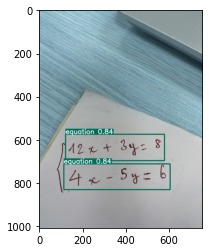

Results saved to runs\detect\exp2054
Done. (0.390s)


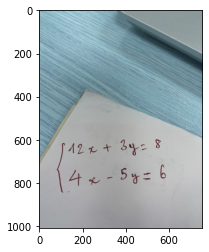

static/single_eq/1611734349


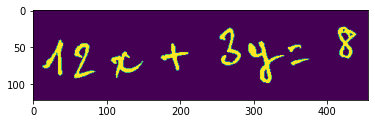

9
S_avg= 1100
s= 216
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 351 w= 24
s= 1548
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 106 w= 43
s= 180
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 347 w= 18
s= 1406
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 174 w= 38
s= 1344
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 56 w= 28
s= 2736
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 293 w= 48
s= 1372
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 13 w= 28
s= 1479
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 254 w= 29
s= 1100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 415 w= 25
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28

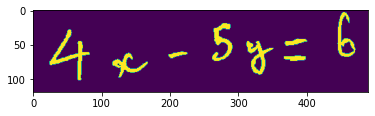

8
S_avg= 1755
s= 256
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 367 w= 32
s= 1872
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 116 w= 52
s= 280
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 198 w= 28
s= 1911
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 312 w= 39
s= 363
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 368 w= 33
s= 4366
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 24 w= 59
s= 1650
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 262 w= 30
s= 1755
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start-x 445 w= 27
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
>>>>>>>>> (28, 28, 3)
(28, 28, 1)
2
1  |  0.99995685


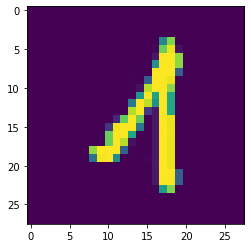

2  |  0.99923396


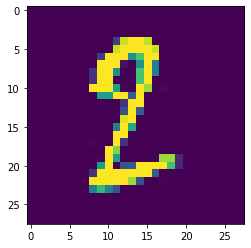

x  |  0.99894494


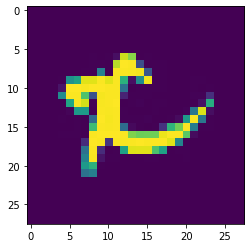

+  |  0.9985073


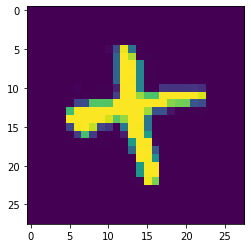

3  |  0.99464345


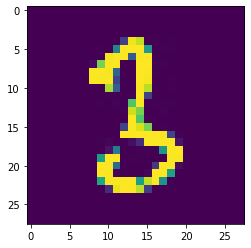

y  |  0.9713272


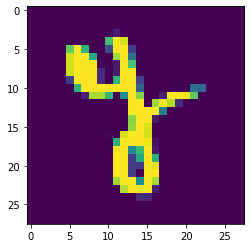

-  |  0.99856746


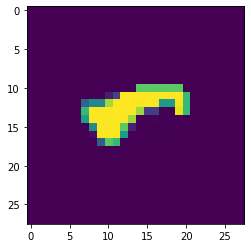

-  |  0.99990034


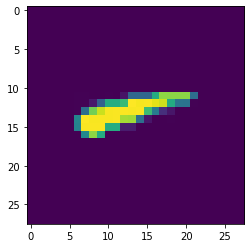

8  |  0.99998665


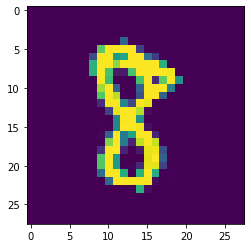

4  |  0.99998987


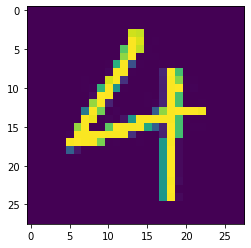

x  |  0.99639064


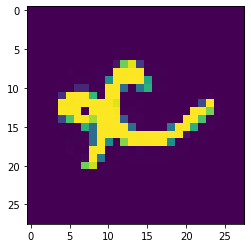

-  |  0.9999547


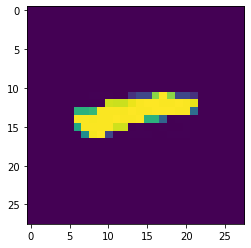

5  |  0.9999778


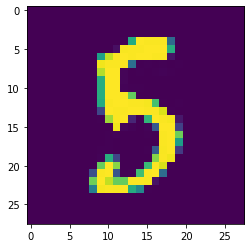

y  |  0.98177415


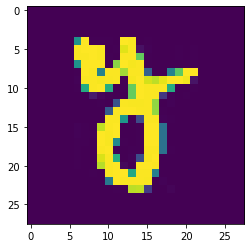

-  |  0.9999939


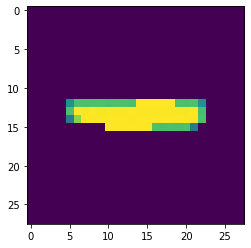

-  |  0.99998593


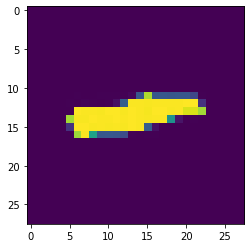

6  |  0.8175574


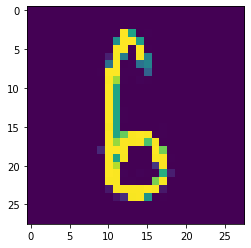

Before: 12x+3y--8 4x-5y--6>>>> After: 12x+3y=8 4x-5y=6
12x+3y=8 4x-5y=6
['12x+3y=8', '4x-5y=6']
list equation: ['+12*x+3*y-8', '+4*x-5*y-6']
{'url': '/pngs/03a7a1ac7d08d8c1cdadcc72c9a0da4f.png', 'result-message': 'success', 'result-code': 0}
{'url': '/pngs/9892459283a5cc9457eafbb42360d6e0.png', 'result-message': 'success', 'result-code': 0}


127.0.0.1 - - [27/Jan/2021 14:59:14] "POST /process HTTP/1.1" 200 -
127.0.0.1 - - [27/Jan/2021 14:59:14] "POST /process HTTP/1.1" 200 -
127.0.0.1 - - [27/Jan/2021 14:59:14] "GET /static/single_eq/1611734349/0.jpg HTTP/1.1" 200 -
127.0.0.1 - - [27/Jan/2021 14:59:14] "GET /static/single_eq/1611734349/0.jpg HTTP/1.1" 200 -


{'url': '/pngs/6fc19692411e9777750211be6fca00f1.png', 'result-message': 'success', 'result-code': 0}
['( x = \\frac{29}{36} , y = - \\frac{5}{9} )']


127.0.0.1 - - [27/Jan/2021 14:59:14] "GET /static/single_eq/1611734349/1.jpg HTTP/1.1" 200 -
127.0.0.1 - - [27/Jan/2021 14:59:14] "GET /static/single_eq/1611734349/1.jpg HTTP/1.1" 200 -


In [ ]:
from flask import Flask, flash, request, redirect, url_for, render_template, send_from_directory, send_file, Markup,jsonify
from IPython.display import clear_output
import json
from werkzeug.utils import secure_filename
app  = Flask(__name__, template_folder= 'templates' )
UPLOAD_FOLDER = r'static\uploads'
app.secret_key = "secret key"
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024
ALLOWED_EXTENSIONS = {'txt', 'pdf', 'png', 'jpg', 'jpeg', 'gif'}

def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

@app.route('/upload', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        if 'file' not in request.files:
            flash('No file part')
            return redirect(request.url)
        file = request.files['file']
        save_path=""
        if file and allowed_file(file.filename):
            filename = secure_filename(file.filename)
            save_path=os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(save_path)
    return save_path

@app.route('/')
def home(): 
    return render_template("index.html")
@app.route('/process', methods=['POST'])
def process():
    torch.cuda.empty_cache()
    clear_output()
    try:
        data = json.loads(request.data)
        print("hahahahaha",data.get('choice'))
        filename=data.get('filename')
        if(data.get('choice')==1):
            print("##################### Using findContours() to detect the characters #####################")
        else:
            print("##################### Using yoloV5 detect the characters #####################")
        print(filename)
        image_path = (filename)
        if(data.get('choice')==0):
            crop_chars=getBounding(image_path)
            ims=preprocessingImgs(crop_chars[0])
        else:
            crop_chars=getBounding2(image_path)
            ims=preprocessingImgs2(crop_chars[0])
        print(len(ims))
        ims_arr=classify(ims,data.get('choice'))
        print(ims_arr)
        res=eq_solver(ims_arr)
        res_latex=convertToLatext(res[0])
        equations_latex=[convertToLatext(i) for i in ims_arr]
        print(res)
    except:
        return jsonify({"status":0,"result":res_latex,"func":ims_arr,"single_eq":crop_chars[1],"equations_latex":equations_latex})
        torch.cuda.empty_cache()
        pass
#     print(single_eq)
    return jsonify({"status":1,"result":res_latex,"func":ims_arr,"single_eq":crop_chars[1],"equations_latex":equations_latex})
if __name__ == "__main__" :
    app.run(host= '0.0.0.0', port=80)

### USING COUNTOURS TO DETECT CHARACTERS

In [ ]:
# def cropChar_using_Countours(path):
#     %matplotlib inline
#     image=cv2.imread(path,cv2.COLOR_BGR2GRAY)
#     image=rgb2gray(image)
#     yen_threshold = threshold_yen(image)
#     image = rescale_intensity(image, (0, yen_threshold), (0, 255))
#     thresh = 230
#     image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY_INV)[1]
#     plt.imshow(image)
#     plt.show()
# ######################################################################################################################3
#     cv2.imwrite(path,image)
#     image = cv2.imread(path)
#     im_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#     im_blur = cv2.GaussianBlur(im_gray,(5,5),0)
#     im,thre = cv2.threshold(im_blur,100,255,cv2.THRESH_BINARY)
#     contours,hierachy = cv2.findContours(thre,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#     rects = [cv2.boundingRect(cnt) for cnt in contours]
#     # print(len(rects))
#     # rects,weights = cv2.groupRectangles(rects, 1, 1.75)
#     print(len(rects))
#     # print(contours)
#     cropimg=[]
#     image_c=image.copy()
#     temp={}
#     crop_chars=[]
#     s=0
#     for i in rects:
#         (x,y,w,h) = i
#         s=s+h*w
#     s=s/len(rects)
#     print("S_avg=",h*w)
#     for i in rects:
#         (x,y,w,h) = i
#         if(w*h>s*1/10):
#             print("s=",w*h)
#             crop = image_c[y:y+h,x:x+w]
# #             plt.imshow(crop)
# #             plt.show()
#             cropimg.append(crop)
# #     j=[int(k) for k in j]
#             temp[x]=image_c[y:y+h,x:x+w].copy()
# #     plt.imshow(image)
# #     plt.show()
#     od = collections.OrderedDict(sorted(temp.items()))    
#     for k,v in od.items(): 
#         crop_chars.append(v)
#     crops=[]
#     count=0
#     for i in crop_chars:
#         height, width,_ = i.shape
#         pad=10
#         if(width>height):
#             left=right=pad
#             top=bottom=int((width+2*pad-height)/2)
#         else:
#             top=bottom=pad
#             left=right=int((height+2*pad-width)/2)
#         hhh = cv2.copyMakeBorder( i, top, bottom, left, right, cv2.BORDER_CONSTANT)
#         h,w,_=hhh.shape
#         s=max(h,w)
#         hhh=cv2.resize(hhh,(s,s))
#         hhh=cv2.resize(hhh,(28,28))
#         tuankq=hhh
#         count=count+1
#         print(">>>>>>>>>",hhh.shape)
#         __=cv2.cvtColor(hhh,cv2.COLOR_RGBA2GRAY)
#         __=np.reshape(__,(28,28,1))
# #         new_array = cv2.resize(new_array, (28,28,1))
# #         __=np.reshape(hhh,(28,28,1))
#         print(__.shape)
#         crops.append(__)
# #         plt.imshow(hhh)
# #         plt.show()
#     return crops
# import re as regex
# def validate(test):
#     _test=test
# #     test="x+2y=3 2z-3y--1"
#     #######################################valid x=z#######################################
#     # for i in range(len(test)):
#     #     if(test[i].isalpha()):
#     #         variables[test[i]]=test.count(test[i])
# #     numbers_of_variables=len(list(variables))
#     numbers_of_valid_variables=len(test.split())
#     # print(variables)
#     if(numbers_of_valid_variables==2):
#         test=test.replace('z','x')
#         test=test.replace('4=','y=')
#     #######################################valid = and -#######################################
#     equations=test.split()
#     for i in range(len(equations)):
#         ######################################3
#         if('--' in equations[i]):
#             equations[i]=equations[i].replace('--','=')
#          ######################################3
#         if('==' in equations[i]):
#             equations[i]=equations[i].replace('==','=')
#          ######################################3
#         if('-=' in equations[i]):
#             equations[i]=equations[i].replace('-=','=')
#          ######################################3
#         if('=' not in equations[i]):
#             temp=list(equations[i])
#             temp[equations[i].rfind('-')]='='
#             equations[i]=''.join(temp)
#          ######################################3
#         while(equations[i].endswith('+') or equations[i].endswith('-') or equations[i].endswith('=')):
#             equations[i]=equations[i][:-1]
#         while(equations[i].startswith('+') or equations[i].endswith('-') or equations[i].endswith('=')):
#             equations[i]=equations[i][1:]
#          ######################################3
#         MATCH_INVALID=regex.findall('(?:x|y|z)[0-9]',equations[i])
#         for c in MATCH_INVALID:
#             while(c in equations[i]):
#                 equations[i]=equations[i].replace(c,c[:-1])
#     test=' '.join(equations)
#     print("Before: "+_test+">>>> After: "+test)
#     return test
# def getBounding(path):
#     %matplotlib inline
#     count=0
#     abc=predict(r'weights\eq_detection\equations_detection-2912.pt',path,0.72)
#     image = cv2.imread(path, cv2.COLOR_BGR2RGB)
#     image1= cv2.imread(path, cv2.COLOR_BGR2RGB)
#     plt.imshow(image)
#     plt.show()
#     xs=[]
#     ys=[]
#     crop_img=[]
#     color=(255,255,0)
#     ###########################
#     #Print each equations:
#     for i in abc:
#         i=[int(j) for j in i]
#         xs+=[i[0],i[2]]
#         ys+=[i[1],i[3]]
#         crop_img.append(image1[i[1]:i[3],i[0]:i[2]].copy())
#         image = cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), color, 3) 
#     count=0
#     rd=str(int(time.time()))
#     foldername=r"C:/Users/tuankq/Desktop/CV_Final_Project/eq_detection/yolov5/static/single_eq/"
#     currentpath=foldername+rd
#     os.makedirs(currentpath)
#     for i in crop_img:
#         im = Image.fromarray(i)
#         im.save(currentpath+'/'+str(count)+".jpg")
#         count+=1
#     crop_chars=[]  
#     print(currentpath)
#     for i in os.listdir(currentpath):
#         crop_chars.append(cropChar_using_Countours(currentpath+'/'+i))
#     return crop_chars,['static/single_eq/'+rd+'/'+str(i)+'.jpg' for i in range(count)]

# from skimage.filters import threshold_yen
# from skimage.exposure import rescale_intensity
# from skimage.io import imread, imsave
# import matplotlib.pyplot as plt
# import cv2
# import os
# import numpy as np

# def preprocessingImgs(crop_imgs):
#     ims=[]
#     for i in crop_imgs:
#         temp=[]
#         for j in i:
#             temp.append(j)
#         ims.append(temp)
#     return [np.array(i) for i in ims]

In [ ]:
im=plt.imread(r'1609336878.jpg')
plt.imshow(im[0:400,0:800])